# Smoothed weekly profile

In [26]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def get_weekly_timestamps():
    """
    Get the date of all Monday in 2020.

    """
    date_start = datetime.date(2020, 1, 1)
    date_end = datetime.date(2020, 12, 31)
    date_start = date_start - datetime.timedelta(days=date_start.weekday())
    date_end = date_end - datetime.timedelta(days=date_end.weekday())
    d = date_start
    weekly_timestamps = []
    while d <= date_end:
        weekly_timestamps.append(d)
        d += datetime.timedelta(7)
    return weekly_timestamps


def get_monthly_timestamps():
    """
    Get the first day of each month in 2020.

    """
    date_start = datetime.date(2020, 1, 1)
    monthly_timestamps = []
    for m in range(1, 13):
        monthly_timestamps.append(date_start.replace(month=m))
    return monthly_timestamps

In [ ]:
def plot_smooth_and_raw_NDVI(filename, x, title):
    labels = [-1, 0, 1, 2]
    means = ['mean', 'mean_smooth', 'mean_smooth10', 'mean_savgol']
    colors_map = {0: 'black', 1: 'tab:red', 2: 'tab:green', -1: 'tab:brown'}
    labels_map = {0: 'no labels', 1: 'apples', 2: 'other crops', -1: 'non crops'}
    means_map = {'mean': 'solid', 'mean_smooth': 'dotted', 'mean_smooth10': 'dashed', 'mean_savgol': 'dashdot'}
    
    ndvi_profile = pd.read_csv(filename)
    fig = plt.subplots(1,1,figsize=(10,6))
    for l in labels:
        for m in means:
            column = f'{m}_{str(l)}'
            plt.plot(x, ndvi_profile[column], color=colors_map[l], linestyle=means_map[m], label=column)
    plt.xlabel('time')
    plt.ylabel('NDVI')
    plt.title(title)
    plt.legend(loc='best')

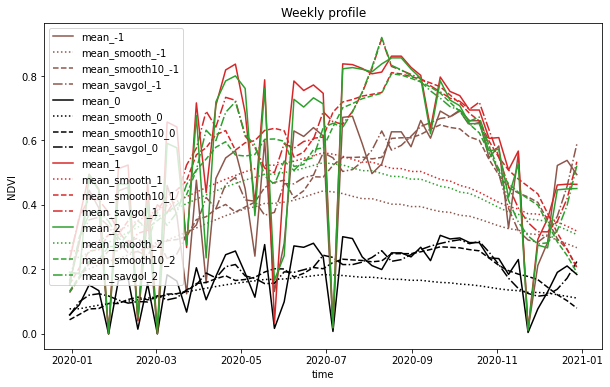

In [41]:
weekly_ts = get_weekly_timestamps()
plot_smooth_and_raw_NDVI(filename='../figs/NDVI weekly profile.csv', x=weekly_ts, title='Weekly profile')

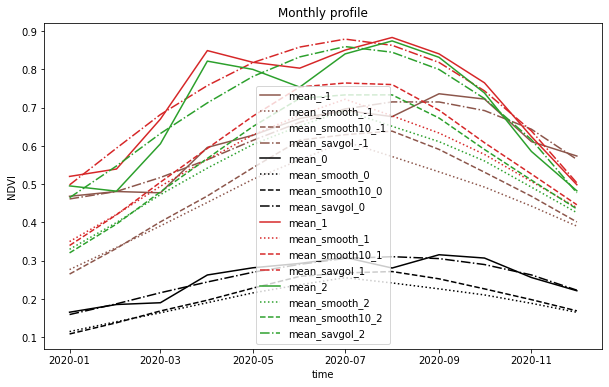

In [42]:
monthly_ts = get_monthly_timestamps()
plot_smooth_and_raw_NDVI(filename='../figs/NDVI monthly profile.csv', x=monthly_ts, title='Monthly profile')

In [54]:
import numpy as np
from scipy.signal import savgol_filter

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [129]:
def several_smoothed_NDVI_of_1_label(label):
    label = str(label)
    ndvi_profile_weekly = pd.read_csv('../figs/NDVI weekly profile.csv')[[f'mean_{label}']]
    ndvi_profile_monthly = pd.read_csv('../figs/NDVI monthly profile.csv')[[f'mean_{label}']]
    
    # weekly smoothed : ['mean', 'smooth_10', 'smooth_30', 'smooth_40', 'savgol_11_3']
    ndvi_profile_weekly['smooth_10'] = smooth(ndvi_profile_weekly[f'mean_{label}'], 10)
    ndvi_profile_weekly['smooth_30'] = smooth(ndvi_profile_weekly[f'mean_{label}'], 30)
    ndvi_profile_weekly['savgol_11_3'] = savgol_filter(ndvi_profile_weekly[f'mean_{label}'], 11, 3)
    ndvi_profile_weekly['savgol_31_3'] = savgol_filter(ndvi_profile_weekly[f'mean_{label}'], 31, 3)
    ndvi_profile_weekly['savgol_11_5'] = savgol_filter(ndvi_profile_weekly[f'mean_{label}'], 11, 5)
    
    return ndvi_profile_monthly, ndvi_profile_weekly
   
    
def plot_several_smoothed_NDVI_of_all_labels():
    from matplotlib import cm
    colors = cm.get_cmap('Dark2').colors
    fig = plt.figure(figsize=(15, 9))
    
    labels = [-1, 0, 1, 2]
    labels_map = {0: 'no labels', 1: 'apples', 2: 'other crops', -1: 'non crops'}
    weekly_ts = get_weekly_timestamps()
    monthly_ts = get_monthly_timestamps()
    
    for n, label in enumerate(labels, start=1):
        ndvi_profile_monthly, ndvi_profile_weekly = several_smoothed_NDVI_of_1_label(label)
        means = ndvi_profile_weekly.columns
        
        ax = fig.add_subplot(2, 2, n)
        # montly mean
        ax.plot(monthly_ts, ndvi_profile_monthly[f'mean_{label}'], 
                 color=colors[0], label='monthly mean')
        # # weekly mean 
        ax.plot(weekly_ts, ndvi_profile_weekly[f'mean_{label}'], 
                 color=colors[0], linewidth=2, alpha=0.5, linestyle='dotted', label='weekly mean')
        # weekly smoothed
        for i, m in enumerate(means):
            if m != f'mean_{label}':
                ax.plot(weekly_ts, ndvi_profile_weekly[m], 
                         color=colors[i], linestyle='solid', label=m)
        ax.set_title(labels_map[label])
        ax.set_xlabel('time')
        ax.set_ylabel('NDVI')
        ax.set_ylim(0,1)
        if n == 2:
            ax.legend(loc='best')
    fig.subplots_adjust(hspace=0.3)
    fig.savefig('../figs/smooth_raw_NDVI.png', bbox_inches='tight', pad_inches=0)

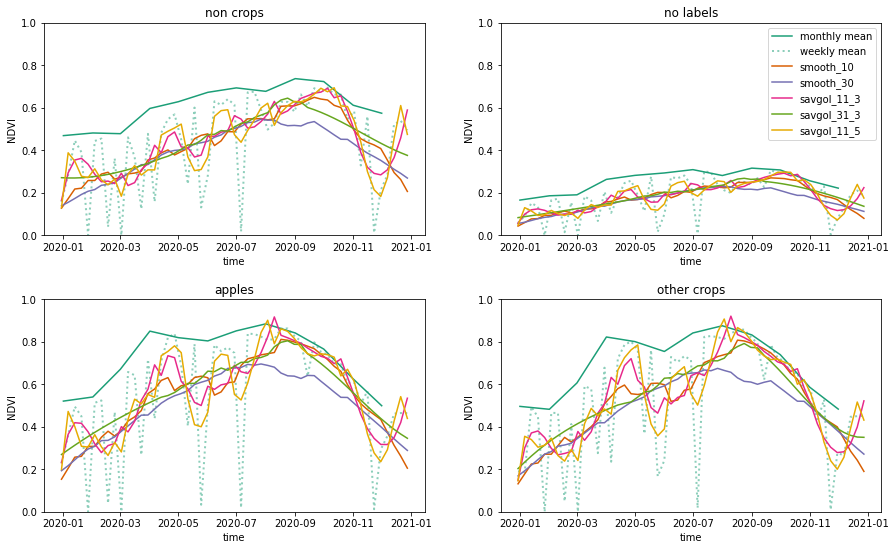

In [130]:
plot_several_smoothed_NDVI_of_all_labels()

In [143]:
def plot_smoothed_weekly_NDVI():
    labels = [-1, 0, 1, 2]
    colors_map = {0: 'black', 1: 'tab:red', 2: 'tab:green', -1: 'tab:brown'}
    labels_map = {0: 'no labels', 1: 'apples', 2: 'other crops', -1: 'non crops'}
    fig = plt.subplots(1,1,figsize=(10,6))

    ndvi_profile = pd.read_csv('../figs/NDVI weekly profile.csv')
    weekly_ts = get_weekly_timestamps()
    
    for label in labels:
        column = f'smoothed_mean_{label}'
        ndvi_profile[column] = smooth(ndvi_profile[f'mean_{label}'], 10)
        plt.plot(weekly_ts, ndvi_profile[column], color=colors_map[label], label=labels_map[label])
        # plt.fill_between(weekly_ts, ndvi_profile[column] - ndvi_profile[f'std_{label}'], 
        #                  ndvi_profile[column] + ndvi_profile[f'std_{label}'], color=colors_map[label], alpha=0.2)
    plt.xlabel('time')
    plt.ylabel('NDVI')
    plt.title('Smoothed weekly profile')
    plt.legend(loc='best')
    plt.savefig('../figs/Smoothed weekly profile.png', bbox_inches='tight', pad_inches=0)

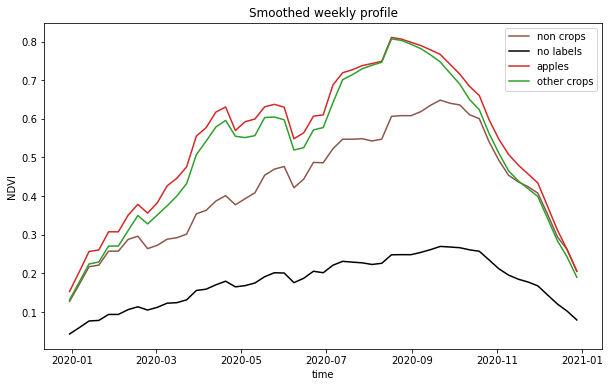

In [144]:
plot_smoothed_weekly_NDVI()

# Load random SVM

In [1]:
import pickle

In [2]:
svm_random = pickle.load(open(f'../models/1006-145601_svm_random.sav', 'rb'))

In [5]:
print(f"Best score {svm_random.best_score_} with best parameters: {svm_random.best_params_}")

Best score 0.706337608919197 with best parameters: {'C': 0.5, 'kernel': 'linear'}


In [6]:
from sklearn.svm import SVC

In [11]:
svm = SVC(C=svm_random.best_params_['C'], 
          kernel=svm_random.best_params_['kernel'])

# PU learning

In [145]:
from pulearn import ElkanotoPuClassifier
from sklearn.svm import SVC

In [154]:
from util import get_log_dir

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



In [ ]:
rfc = pickle.load(open(f'../models/1001-184445_rfc.sav', 'rb'))
y_pred = rfc.predict(x)

In [ ]:
svc = SVC(C=10, kernel='rbf', gamma=0.4, probability=True)
pu_estimator = ElkanotoPuClassifier(estimator=svc, hold_out_ratio=0.2)
pu_estimator.fit(X, y)